# Demos: Lecture 13

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

## Demo 1: Parameter-shift rules

Suppose we run a parametrized circuit $U(\theta)$ and measure $\langle B \rangle$. The output, $\langle B \rangle$, is a function of the parameter $\theta$. The parameter-shift rule allows us to evaluate the gradient of this function at any point:

$$
\frac{\partial \langle B \rangle}{\partial \theta} = \frac{1}{2} \left( U(\theta + \pi/2) - U(\theta - \pi/2) \right),
$$

where the notation $U(\theta + \pi/2)$ implicitly means the output of running $U(\theta)$ at a particular parameter value. This works even for circuits with multiple parameters: we can apply the parameter-shift rule to each parameter independently.

**Exercise**: Write a QNode that implements the quantum circuit below. Then:
 - use the parameter-shift rules to compute the gradients with respect to each of the parameters ($\theta = 0.1, \phi = 0.2$) indepedently
 - compare this to the gradients obtained using `qml.grad` on both parameters

<img src="fig/two_param_opt.png">

In [13]:
dev = qml.device('default.qubit', wires=2)

# @qml.qnode(dev)
@qml.qnode(dev, diff_method="parameter-shift")
def paramCirc(theta, phi):
    qml.RY(theta, wires=0)
    qml.RX(phi, wires=1)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,0])

    return qml.expval(qml.PauliZ(0) @ qml.PauliX(1))


In [14]:
0.5 * (paramCirc(0.1 + np.pi/2, 0.2) - paramCirc(0.1 - np.pi/2, 0.2))

tensor(0.97517033, requires_grad=True)

In [15]:
0.5 * (paramCirc(0.1, 0.2 + np.pi/2) - paramCirc(0.1, 0.2 - np.pi/2))

tensor(-0.01983384, requires_grad=True)

In [19]:
theta = np.array(0.1, requires_grad = True)
phi = np.array(0.2, requires_grad = True)

grad_func = qml.grad(paramCirc)
grad_func(theta, phi)

(tensor(0.97517033, requires_grad=True),
 tensor(-0.01983384, requires_grad=True))

In [30]:
theta = np.array(0., requires_grad = True)
phi = np.array(0., requires_grad = True)

opt = qml.GradientDescentOptimizer()
num_iter = 200
running_costs = []

for _ in range(num_iter):
    (theta, phi), _cost = opt.step_and_cost(paramCirc, theta, phi) # Takes in 1.func to optimize, 2. Params
    running_costs.append(_cost)

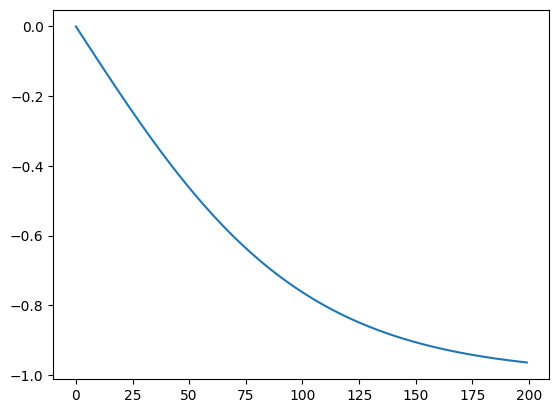

In [31]:
plt.plot(running_costs) # this has range [-1, 1]

In [32]:
theta

tensor(-1.30352431, requires_grad=True)

In [33]:
phi

tensor(0., requires_grad=True)

## Demo 2: Variational eigensolver

Below we construct the two-qubit Hamiltonian 

$$
\hat{H} = 0.5 Z \otimes Z + 1.5 X \otimes X
$$

and use the VQE to find its ground state energy.

In [20]:
coeffs = [0.5, 1.5]
ops = [qml.PauliZ(0) @ qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]

H = qml.Hamiltonian(coeffs, ops)

## Demo 3: VQE for the deuteron

Below is a Hamiltonian for a _real_ physical system: a deuteron. The ground state of this Hamiltonian is a linear combination of 4 basis states with *real-valued* coefficients, i.e.,

$$
|\psi_g\rangle = a |1000\rangle + b|0100\rangle + c |0010\rangle + d |0001\rangle
$$

**Exercise**: Implement the VQE to find the ground state energy of this Hamiltonian.

*Hint*: To create a suitable ansatz circuit, try generalizing the one from the previous demo.

In [3]:
coeffs = [28.657, 0.218, -6.125, -9.625, -13.125, -2.143, -3.913, -5.671, -2.143, -3.913, -5.671]

ops = [
    qml.Identity(0), 
    qml.PauliZ(0),
    qml.PauliZ(1),
    qml.PauliZ(2),
    qml.PauliZ(3),
    qml.PauliX(0) @ qml.PauliX(1),
    qml.PauliX(1) @ qml.PauliX(2),
    qml.PauliX(2) @ qml.PauliX(3),
    qml.PauliY(0) @ qml.PauliY(1),
    qml.PauliY(1) @ qml.PauliY(2),
    qml.PauliY(2) @ qml.PauliY(3)
]

H = qml.Hamiltonian(coeffs, ops)